# Colombia data

Data from Colombian population.

See de la Cuesta-Zuluaga et al. 2018 - https://doi.org/10.1038/s41598-018-29687-x

## Libraries

In [1]:
library(ggplot2) # Graphs
library(cowplot) #plot_grid
library(tidyverse) # Data manipulation
library(broom) # Multiple linear models
library(scales) # ggplot breaks
library(tableone) # Participant description
library(lspline) # Linear splines


Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ tibble  1.4.2     ✔ purrr   0.2.5
✔ tidyr   0.8.1     ✔ dplyr   0.7.6
✔ readr   1.1.1     ✔ stringr 1.3.1
✔ tibble  1.4.2     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()   masks stats::filter()
✖ cowplot::ggsave() masks ggplot2::ggsave()
✖ dplyr::lag()      masks stats::lag()

Attaching package: ‘scales’

The following object is masked from ‘package:purrr’:

    discard

The following object is masked from ‘package:readr’:

    col_factor



## Load and organize data


In [2]:
# Metadata table
microbio.meta = read.table(file = "./data/microbio_selected.meta",
                           header = T, sep = "\t", dec = ",", row.names = 1)


# OTU table
microbio.richness = read.table(file = "./data/Qiime_Col_richness.tsv", 
                               header = T, sep = "\t", row.names = 1)

# Phylogenetic tree
microbio.shannon = read.table(file = "./data/Qiime_Col_shannon.tsv", 
                              header = T, sep = "\t", row.names = 1)

#### Adjust sample names and create a single data frame

In [3]:
# Alpha-diversity table
alpha_dat = merge(microbio.shannon, microbio.richness, by = "row.names", all = T)
rownames(alpha_dat) = alpha_dat$Row.names %>% sub(pattern = "11993.", replacement = "", fixed = T) 
alpha_dat$Row.names =  NULL

# Verify that names are equal in both data frames
(rownames(alpha_dat) %in% rownames(microbio.meta) ) %>% sum

# Create a single data frame
alpha_age_dat = merge(alpha_dat, microbio.meta[,c("age", "sex")], by = "row.names", all = T)
rownames(alpha_age_dat) = alpha_age_dat$Row.names
alpha_age_dat$Row.names =  NULL
alpha_age_dat %>% head

[1] 441

,shannon,observed_otus,age,sex
MI001H,5.803678,159,36,Male
MI002H,5.016472,156,40,Female
MI003H,3.817352,62,53,Male
MI004H,5.684056,154,58,Male
MI005H,5.260125,114,44,Female
MI006H,5.802381,143,43,Male


We will create a variable called `age_range`. Subjects younger than 20 should will be removed.
Thus, instead of 18-40 and 41-62 used in the original study, the groups should be 20-45 and 46-62.

In [4]:
# Remove
young = which(alpha_age_dat$age < 20)
# Data of samples removed due to age
alpha_age_dat[young,]

alpha_age_dat = alpha_age_dat[-young,]
microbio.meta = microbio.meta[-young,]
alpha_age_dat$age %>% range()
alpha_age_dat %>% nrow()

# Recode age groups
alpha_age_dat$age_range = alpha_age_dat$age %>%
  cut(.,breaks = c(20,45,62), include.lowest = T,
      labels = c("20 - 45", "46 - 62"))

,shannon,observed_otus,age,sex
MI022H,1.258187,31,19,Female
MI108H,5.516527,145,18,Female
MI180H,4.757634,121,18,Male
MI233H,4.701260,114,18,Female


[1] 20 62

[1] 437

## Alpha-diversity analyses

In [5]:
# Plot parameters
plot_alpha = 0.20
x_breaks = 3
font_size = 10
Palette <- c("#D55E00", "#0072B2")
options(repr.plot.width=7, repr.plot.height=3) # default is 7x7

### Compare linear model and spline regression of alpha-diversity and age

To test whether a linear o a non-linear model better explains the association between age and alpha-diversity, we will fit a linear regression using linear splines with a knot at 45 years of age and compare it with a simple linear model of alpha-diversity and age using the Akaike information criterion (AIC). Recall that the lower the AIC, the higher the quality of a model.

In [6]:
# Richness
rich_null <- lm(observed_otus~1, data = alpha_age_dat)
rich_lm <- lm(observed_otus~age, data = alpha_age_dat)
rich_ls <- lm(observed_otus~lspline(age, c(45)), data = alpha_age_dat)

AIC_rich = c(fit0 = AIC(rich_null), fit1 = AIC(rich_lm), fit2 = AIC(rich_ls)) %>%
  print

rich_ls %>% summary


# Shannon Index
shannon_null <- lm(shannon~1, alpha_age_dat)
shannon_lm <- lm(shannon~age, data = alpha_age_dat)
shannon_ls <- lm(shannon~lspline(age, c(45)), data = alpha_age_dat)

AIC_rich = c(fit0 = AIC(shannon_null), fit1 = AIC(shannon_lm), fit2 = AIC(shannon_ls)) %>%
  print

shannon_ls %>% summary

    fit0     fit1     fit2 
4269.746 4264.894 4264.599 



Call:
lm(formula = observed_otus ~ lspline(age, c(45)), data = alpha_age_dat)

Residuals:
    Min      1Q  Median      3Q     Max 
-95.481 -20.429   1.077  20.821  85.519 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)           92.9487     8.5598  10.859   <2e-16 ***
lspline(age, c(45))1   0.6543     0.2369   2.762    0.006 ** 
lspline(age, c(45))2  -0.2123     0.4055  -0.524    0.601    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 31.65 on 434 degrees of freedom
Multiple R-squared:  0.02071,	Adjusted R-squared:  0.0162 
F-statistic:  4.59 on 2 and 434 DF,  p-value: 0.01065


    fit0     fit1     fit2 
1308.832 1306.035 1305.048 



Call:
lm(formula = shannon ~ lspline(age, c(45)), data = alpha_age_dat)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.0570 -0.6105  0.2422  0.7961  1.7037 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)           3.775600   0.289634  13.036  < 2e-16 ***
lspline(age, c(45))1  0.021514   0.008017   2.684  0.00756 ** 
lspline(age, c(45))2 -0.011952   0.013720  -0.871  0.38417    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.071 on 434 degrees of freedom
Multiple R-squared:  0.01765,	Adjusted R-squared:  0.01313 
F-statistic:   3.9 on 2 and 434 DF,  p-value: 0.02096


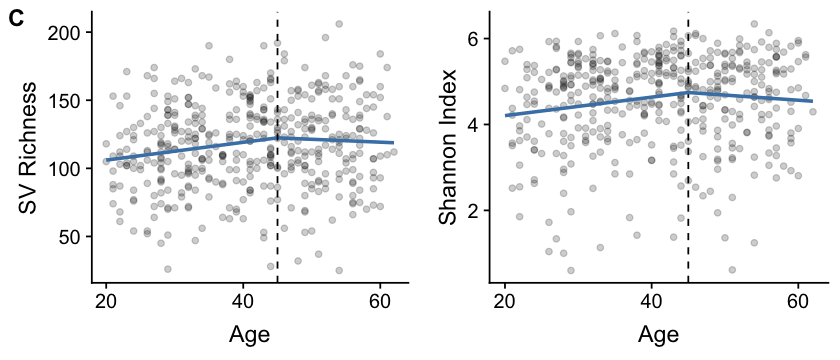

In [7]:
richness_spline = ggplot(alpha_age_dat, aes(x = age, y = observed_otus)) + 
    geom_point(alpha = plot_alpha) +
    geom_smooth(method = "lm", formula = y~lspline(x, c(45)), se = F, color = "steelblue") +
    geom_vline(xintercept = c(45), linetype="dashed") +
    labs(x = "Age", y = "SV Richness") +
    scale_x_continuous(breaks = pretty_breaks(n = x_breaks))

shannon_spline = ggplot(alpha_age_dat, aes(x = age, y = shannon)) + 
    geom_point(alpha = plot_alpha) +
    geom_vline(xintercept = c(45), linetype="dashed") +
    geom_smooth(method = "lm", formula = y~lspline(x, c(45)), se = F, color = "steelblue") +
    labs(x = "Age", y = "Shannon Index") +
    scale_x_continuous(breaks = pretty_breaks(n = x_breaks)) 

alpha_div_spline = plot_grid(richness_spline, shannon_spline,
          nrow = 1, labels = c("C", ""))

ggsave(filename = "./images/col_alpha_splines.png", 
       plot = alpha_div_spline, device = "png", dpi = "print", width = 7, height = 3)


plot(alpha_div_spline)


Next, we will plot alpha-diversity metrics by age as a continuous variable, colored by sex. 
In this case, we will plot a loess (local regression) curve to show the non-linear association between
age and alpha-diversity. Considering that the curve flattens after 40 years of age, 
we will use the two age categories previously established, replicate the plots and trace
linear regression lines.

In [8]:
richness_age = ggplot(alpha_age_dat, aes(x = age, y = observed_otus, color = sex)) +
  geom_point(alpha = plot_alpha) +
  geom_smooth(method="loess", se = F) +
  labs(x = "Age", y = "SV Richness") +
  scale_x_continuous(breaks = pretty_breaks(n = x_breaks)) +
  scale_color_manual(values=Palette) +
  theme(legend.position="none")

shannon_age = ggplot(alpha_age_dat, aes(x = age, y = shannon, color = sex)) +
  geom_point(alpha = plot_alpha) +
  geom_smooth(method="loess", se = F) +
  labs(x = "Age", y = "Shannon Index") +
  scale_x_continuous(breaks = pretty_breaks(n = x_breaks)) +
  scale_color_manual(values=Palette) +
  theme(legend.position="none")

richness_age_range = ggplot(alpha_age_dat, aes(x = age, y = observed_otus, color = sex)) +
  geom_point(alpha = plot_alpha) +
  geom_smooth(method="lm", se = F) + 
  facet_wrap(~ age_range, scales = "free_x") +
  labs(x = "Age", y = "SV Richness") +
  scale_x_continuous(breaks = pretty_breaks(n = x_breaks)) +
  scale_color_manual(values=Palette) +
  theme(legend.position="none")

shannon_age_range = ggplot(alpha_age_dat, aes(x = age, y = shannon, color = sex)) +
  geom_point(alpha = plot_alpha) +
  geom_smooth(method="lm", se = F) + 
  facet_wrap(~ age_range, scales = "free_x") +
  labs(x = "Age", y = "Shannon Index") +
  scale_x_continuous(breaks = pretty_breaks(n = x_breaks)) +
  scale_color_manual(values=Palette) +
  theme(legend.position="none")

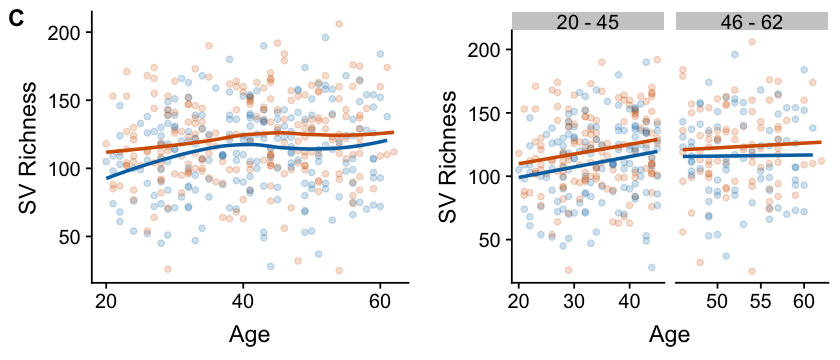

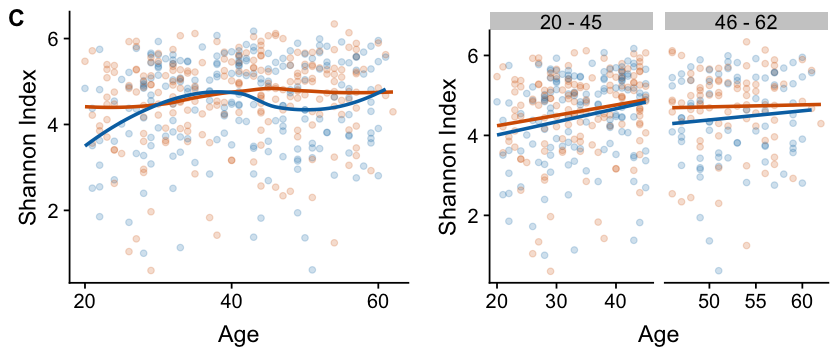

In [9]:
# Manuscript plots
col_rich_gph = plot_grid(richness_age, richness_age_range, ncol = 2, labels = c("C", ""))

col_shann_gph = plot_grid(shannon_age, shannon_age_range , ncol = 2, labels = c("C", ""))

plot(col_rich_gph)
plot(col_shann_gph)

In [10]:
ggsave(filename = "./images/col_rich_gph.png", 
       plot = col_rich_gph, device = "png", dpi = "print", width = 7, height = 3)

ggsave(filename = "./images/col_shann_gph.png", 
       plot = col_shann_gph, device = "png", dpi = "print", width = 7, height = 3)

Also, to show the change in the linear association between alpha-diversity and sex
between age categories, we will calcule Pearsons's correlation coefficient by sex and age group
for each of the alpha-diversity indices.

In [11]:
alpha_age_dat  %>% group_by(age_range, sex) %>% 
  summarise(rho=cor(observed_otus, age, method = "p"))
alpha_age_dat  %>% group_by(age_range, sex) %>% 
  summarise(rho=cor(shannon, age, method = "p"))

age_range,sex,rho
20 - 45,Female,0.18265270
20 - 45,Male,0.18470100
46 - 62,Female,0.04690331
46 - 62,Male,0.01047736


age_range,sex,rho
20 - 45,Female,0.17774633
20 - 45,Male,0.20519966
46 - 62,Female,0.02129252
46 - 62,Male,0.08886731


Afterwards, we will fit an linear model of alpha-diversity and sex in the complete dataset.

Given that the interactions are non-significant, we will drop them from the model

In [12]:
# Empty data frame for p-values
pvals = data.frame(Population = character(), Metric = character(), Test = character(), pval = numeric())

In [13]:
# Testing with no interaction term
# SV richness
richness_lm_young = alpha_age_dat %>% 
    filter(age_range == "20 - 45") %>%
    lm(observed_otus ~ age, data = .)
summary(richness_lm_young)

richness_lm_old = alpha_age_dat %>% 
    filter(age_range == "46 - 62") %>%
    lm(observed_otus ~ age, data = .)
summary(richness_lm_old)

sv_age_y = summary(richness_lm_young) %>%
    pluck(coefficients) %>% 
    as.data.frame %>% 
    select('Pr(>|t|)') %>% 
    slice(2) %>%
    as.numeric

pvals = rbind(pvals, data.frame(Population = "Col", Metric = "Richness", Test = "age_young", pval = sv_age_y))

sv_age_m = summary(richness_lm_old) %>%
    pluck(coefficients) %>% 
    as.data.frame %>% 
    select('Pr(>|t|)') %>% 
    slice(2) %>%
    as.numeric

pvals = rbind(pvals, data.frame(Population = "Col", Metric = "Richness", Test = "age_middle", pval = sv_age_m))


Call:
lm(formula = observed_otus ~ age, data = .)

Residuals:
    Min      1Q  Median      3Q     Max 
-95.452 -19.854   1.358  19.905  73.497 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  89.4774     9.0137   9.927  < 2e-16 ***
age           0.7722     0.2595   2.976  0.00318 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 30.52 on 274 degrees of freedom
Multiple R-squared:  0.03131,	Adjusted R-squared:  0.02778 
F-statistic: 8.857 on 1 and 274 DF,  p-value: 0.003181



Call:
lm(formula = observed_otus ~ age, data = .)

Residuals:
   Min     1Q Median     3Q    Max 
-95.07 -22.36   1.00  22.75  85.93 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 110.4016    32.8325   3.363 0.000967 ***
age           0.1791     0.6212   0.288 0.773446    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 33.53 on 159 degrees of freedom
Multiple R-squared:  0.0005227,	Adjusted R-squared:  -0.005763 
F-statistic: 0.08315 on 1 and 159 DF,  p-value: 0.7734


In [14]:
# Shannon Index
shannon_lm_young = alpha_age_dat %>% 
    filter(age_range == "20 - 45") %>%
    lm(shannon ~ age, data = .)
summary(shannon_lm_young)

shannon_lm_old = alpha_age_dat %>% 
    filter(age_range == "46 - 62") %>%
    lm(shannon ~ age, data = .)
summary(shannon_lm_old)

sh_age_y = summary(shannon_lm_young) %>%
    pluck(coefficients) %>% 
    as.data.frame %>% 
    select('Pr(>|t|)') %>% 
    slice(2) %>%
    as.numeric

pvals = rbind(pvals, data.frame(Population = "Col", Metric = "Shannon", Test = "age_young", pval = sh_age_y))

sh_age_m = summary(shannon_lm_old) %>%
    pluck(coefficients) %>% 
    as.data.frame %>% 
    select('Pr(>|t|)') %>% 
    slice(2) %>%
    as.numeric

pvals = rbind(pvals, data.frame(Population = "Col", Metric = "Shannon", Test = "age_middle", pval = sh_age_m))


Call:
lm(formula = shannon ~ age, data = .)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.7955 -0.5649  0.2656  0.7637  1.6194 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 3.557307   0.315390  11.279  < 2e-16 ***
age         0.028926   0.009079   3.186  0.00161 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.068 on 274 degrees of freedom
Multiple R-squared:  0.03573,	Adjusted R-squared:  0.03221 
F-statistic: 10.15 on 1 and 274 DF,  p-value: 0.001608



Call:
lm(formula = shannon ~ age, data = .)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.9576 -0.6742  0.1980  0.8117  1.7292 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.92678    1.04760   3.748 0.000249 ***
age          0.01266    0.01982   0.639 0.523802    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.07 on 159 degrees of freedom
Multiple R-squared:  0.002561,	Adjusted R-squared:  -0.003712 
F-statistic: 0.4082 on 1 and 159 DF,  p-value: 0.5238


Similar to the way we constructed the plots, we will test the association between
age and sex in each age group separately.

In [15]:
# Fit separate linear models by each age group
# SV richness
richness_group_lm = alpha_age_dat %>% group_by(age_range) %>%
  do(richn_lm = lm(observed_otus ~ sex + age, data = .)  %>% summary())

# get the coefficients by group in a tidy data_frame
otu_group_coef = tidy(richness_group_lm, richn_lm)
otu_group_coef

# R2 of the regression
otu_group_R2 = glance(richness_group_lm, richn_lm)
otu_group_R2

sv_age_sex_y = otu_group_coef %>% 
    select(age_range, term, p.value) %>% 
    filter(age_range == "20 - 45" & term == "sexMale") %>% 
    pull(p.value)

pvals = rbind(pvals, data.frame(Population = "Col", Metric = "Richness", Test = "age_sex_young", pval = sv_age_sex_y))

sv_age_sex_m = otu_group_coef %>% 
    select(age_range, term, p.value) %>% 
    filter(age_range == "46 - 62" & term == "sexMale") %>% 
    pull(p.value)

pvals = rbind(pvals, data.frame(Population = "Col", Metric = "Richness", Test = "age_sex_middle", pval = sv_age_sex_m))

age_range,term,estimate,std.error,statistic,p.value
20 - 45,(Intercept),93.6447639,9.035208,10.3644278,1.923824e-21
20 - 45,sexMale,-10.0032527,3.634408,-2.7523744,6.312991e-03
20 - 45,age,0.7913580,0.256498,3.0852407,2.242725e-03
46 - 62,(Intercept),111.7302417,32.753341,3.4112624,8.211240e-04
46 - 62,sexMale,-7.2888961,5.278230,-1.3809357,1.692489e-01
46 - 62,age,0.2209343,0.620159,0.3562543,7.221254e-01


age_range,r.squared,adj.r.squared,sigma,statistic,p.value,df
20 - 45,0.05746592,5.056091e-02,30.15868,8.3223503,0.0003101335,3
46 - 62,0.01244204,-5.869176e-05,33.43055,0.9953049,0.3719159908,3


In [16]:
# Shannon index
shannon_group_lm = alpha_age_dat %>% group_by(age_range) %>%
  do(shann_lm = lm(shannon ~ sex + age, data = .) %>% summary())

# get the coefficients by group in a tidy data_frame
shannon_group_coef = tidy(shannon_group_lm, shann_lm)
shannon_group_coef

# R2 of the regression
shannon_group_R2 = glance(shannon_group_lm, shann_lm)
shannon_group_R2

sh_age_sex_y = shannon_group_coef %>% 
    select(age_range, term, p.value) %>% 
    filter(age_range == "20 - 45" & term == "sexMale") %>% 
    pull(p.value)

pvals = rbind(pvals, data.frame(Population = "Col", Metric = "Shannon", Test = "age_sex_young", pval = sh_age_sex_y))

sh_age_sex_m = otu_group_coef %>% 
    select(age_range, term, p.value) %>% 
    filter(age_range == "46 - 62" & term == "sexMale") %>% 
    pull(p.value)

pvals = rbind(pvals, data.frame(Population = "Col", Metric = "Shannon", Test = "age_sex_middle", pval = sh_age_sex_m))

age_range,term,estimate,std.error,statistic,p.value
20 - 45,(Intercept),3.61370576,0.319851269,11.2980817,1.540908e-24
20 - 45,sexMale,-0.13537675,0.128660030,-1.0522052,2.936359e-01
20 - 45,age,0.02918605,0.009080168,3.2142636,1.464865e-03
46 - 62,(Intercept),3.97755178,1.042334358,3.8160037,1.942675e-04
46 - 62,sexMale,-0.27855437,0.167973103,-1.6583272,9.923541e-02
46 - 62,age,0.01426122,0.019735789,0.7226068,4.709897e-01


age_range,r.squared,adj.r.squared,sigma,statistic,p.value,df
20 - 45,0.03962175,0.032586014,1.067634,5.631499,0.004012139,3
46 - 62,0.01962454,0.007214724,1.063886,1.581372,0.208930624,3


Including the interaction term in the models by age groups

In [17]:
# Fit separate linear models by each age group
# SV richness
richness_group_lm = alpha_age_dat %>% group_by(age_range) %>%
  do(richn_lm = lm(observed_otus ~ sex * age, data = .)  %>% summary())

# get the coefficients by group in a tidy data_frame
otu_group_coef = tidy(richness_group_lm, richn_lm)
otu_group_coef

# R2 of the regression
otu_group_R2 = glance(richness_group_lm, richn_lm)
otu_group_R2

sv_age_sex_inter_y = otu_group_coef %>% 
    select(age_range, term, p.value) %>% 
    filter(age_range == "20 - 45" & term == "sexMale:age") %>% 
    pull(p.value)

pvals = rbind(pvals, data.frame(Population = "Col", Metric = "Richness", Test = "age_sex_interaction_young", pval = sv_age_sex_inter_y))

sv_age_sex_inter_m = otu_group_coef %>% 
    select(age_range, term, p.value) %>% 
    filter(age_range == "46 - 62" & term == "sexMale:age") %>% 
    pull(p.value)

pvals = rbind(pvals, data.frame(Population = "Col", Metric = "Richness", Test = "age_sex_interaction_middle", pval = sv_age_sex_inter_m))

age_range,term,estimate,std.error,statistic,p.value
20 - 45,(Intercept),94.53384115,12.1564080,7.7764617,1.548576e-13
20 - 45,sexMale,-11.92401572,17.9049009,-0.6659638,5.059986e-01
20 - 45,age,0.76507354,0.3515414,2.1763397,3.039031e-02
20 - 45,sexMale:age,0.05644145,0.5151407,0.1095651,9.128351e-01
46 - 62,(Intercept),103.83288956,47.1301583,2.2031093,2.904381e-02
46 - 62,sexMale,8.03637900,65.7919661,0.1221483,9.029378e-01
46 - 62,age,0.37141188,0.8952840,0.4148537,6.788153e-01
46 - 62,sexMale:age,-0.29089878,1.2447895,-0.2336932,8.155276e-01


age_range,r.squared,adj.r.squared,sigma,statistic,p.value,df
20 - 45,0.05750752,0.047112383,30.21340,5.5321558,0.001061818,4
46 - 62,0.01278544,-0.006078528,33.53102,0.6777705,0.566890258,4


In [18]:
# Shannon index
shannon_group_lm = alpha_age_dat %>% group_by(age_range) %>%
  do(shann_lm = lm(shannon ~ sex * age, data = .) %>% summary())

# get the coefficients by group in a tidy data_frame
shannon_group_coef = tidy(shannon_group_lm, shann_lm)
shannon_group_coef

# R2 of the regression
shannon_group_R2 = glance(shannon_group_lm, shann_lm)
shannon_group_R2

sh_age_sex_inter_y = shannon_group_coef %>% 
    select(age_range, term, p.value) %>% 
    filter(age_range == "20 - 45" & term == "sexMale:age") %>% 
    pull(p.value)

pvals = rbind(pvals, data.frame(Population = "Col", Metric = "Shannon", Test = "age_sex_interaction_young", pval = sh_age_sex_inter_y))

sh_age_sex_inter_m = shannon_group_coef %>% 
    select(age_range, term, p.value) %>% 
    filter(age_range == "46 - 62" & term == "sexMale:age") %>% 
    pull(p.value)

pvals = rbind(pvals, data.frame(Population = "Col", Metric = "Shannon", Test = "age_sex_interaction_middle", pval = sh_age_sex_inter_m))

age_range,term,estimate,std.error,statistic,p.value
20 - 45,(Intercept),3.721871814,0.43024075,8.6506724,4.534052e-16
20 - 45,sexMale,-0.369058745,0.63369197,-0.5823945,5.607834e-01
20 - 45,age,0.025988255,0.01244179,2.0887879,3.765645e-02
20 - 45,sexMale:age,0.006866725,0.01823191,0.3766323,7.067406e-01
46 - 62,(Intercept),4.458539708,1.49916392,2.9740175,3.403640e-03
46 - 62,sexMale,-1.211939660,2.09277765,-0.5791058,5.633477e-01
46 - 62,age,0.005096386,0.02847810,0.1789581,8.582014e-01
46 - 62,sexMale:age,0.017717179,0.03959553,0.4474541,6.551640e-01


age_range,r.squared,adj.r.squared,sigma,statistic,p.value,df
20 - 45,0.04012234,0.029535456,1.069316,3.789815,0.01089835,4
46 - 62,0.02087318,0.002163748,1.066589,1.115650,0.34455445,4


In [19]:
# Save pvalues table
pval_file = file.path("../pvalues/Col_pval.tsv")
write.table(pvals, pval_file, sep = "\t", dec = ".", quote = F, row.names = F)

### Influence of cardiometabolic health
There are significant differences in alpha-diversity by age and sex, however, these
associations may be confounded by the cardiometabolic health of the subjects. It is known
that cardiometabolic health decreases with age, and that the diversity of the gut microbiome
is inversely correlated with health. Therefore, we will test for the above associations 
while controling for cardiometabolic health.

First, we will calculate a metabolic-syndrome score based on diverse host biomarkers.
The MS score is the sum of the z-scores of health associated parameters, namely,
waist circumference, triglycerides, insulin, diastolic blood pressure and high-sensitivity
C-reactive protein; positive values of the MS score are associated with increase cardiometabolic health risk.

In [20]:
# Z-scores of host biomarkers
z_WC = log(microbio.meta$waist) %>% scale(., center = TRUE, scale = TRUE)
z_TG = log(microbio.meta$triglycerides) %>% scale(., center = TRUE, scale = TRUE)
z_insulin = log(microbio.meta$insulin) %>% scale(., center = TRUE, scale = TRUE)
z_DBP = log(microbio.meta$diastolic_bp) %>% scale(., center = TRUE, scale = TRUE)
z_hsCRP = log(microbio.meta$hsCRP) %>% scale(., center = TRUE, scale = TRUE)

# Metabolic syndrome score
MS_score = (z_WC + z_TG + z_insulin + z_DBP + z_hsCRP) %>% as.numeric()
MS_score %>% summary
alpha_age_dat$ms_score = MS_score 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-8.6468 -2.4722  0.2466  0.0000  2.4029  9.5046 

In [21]:
# Replace the alpha-diversity indices for their residuals after regressing the MS score
adj_alpha_age = alpha_age_dat
adj_alpha_age$observed_otus = lm(observed_otus ~ ms_score, data = alpha_age_dat)$residuals
adj_alpha_age$shannon = lm(shannon ~ ms_score, data = alpha_age_dat)$residuals

Linear splines

In [22]:
# Richness
adj_rich_null <- lm(observed_otus~1, data = adj_alpha_age)
adj_rich_lm <- lm(observed_otus~age, data = adj_alpha_age)
adj_rich_ls <- lm(observed_otus~lspline(age, c(45)), data = adj_alpha_age)

adj_AIC_rich = c(fit0 = AIC(adj_rich_null), fit1 = AIC(adj_rich_lm), fit2 = AIC(adj_rich_ls)) %>%
  print

adj_rich_ls %>% summary


# Shannon Index
adj_shannon_null <- lm(shannon~1, adj_alpha_age)
adj_shannon_lm <- lm(shannon~age, data = adj_alpha_age)
adj_shannon_ls <- lm(shannon~lspline(age, c(45)), data = adj_alpha_age)

adj_AIC_rich = c(fit0 = AIC(adj_shannon_null), fit1 = AIC(adj_shannon_lm), fit2 = AIC(adj_shannon_ls)) %>%
  print

adj_shannon_ls %>% summary

    fit0     fit1     fit2 
4259.744 4251.802 4251.421 



Call:
lm(formula = observed_otus ~ lspline(age, c(45)), data = adj_alpha_age)

Residuals:
    Min      1Q  Median      3Q     Max 
-94.371 -20.116   1.094  22.813  85.264 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)   
(Intercept)          -27.1417     8.4317  -3.219  0.00138 **
lspline(age, c(45))1   0.7240     0.2334   3.102  0.00205 **
lspline(age, c(45))2  -0.1457     0.3994  -0.365  0.71541   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 31.18 on 434 degrees of freedom
Multiple R-squared:  0.02781,	Adjusted R-squared:  0.02333 
F-statistic: 6.207 on 2 and 434 DF,  p-value: 0.0022


    fit0     fit1     fit2 
1306.151 1302.119 1301.095 



Call:
lm(formula = shannon ~ lspline(age, c(45)), data = adj_alpha_age)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.9736 -0.6522  0.2476  0.7966  1.6992 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)   
(Intercept)          -0.83487    0.28833  -2.896  0.00398 **
lspline(age, c(45))1  0.02274    0.00798   2.849  0.00459 **
lspline(age, c(45))2 -0.01078    0.01366  -0.789  0.43029   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.066 on 434 degrees of freedom
Multiple R-squared:  0.02051,	Adjusted R-squared:  0.01599 
F-statistic: 4.543 on 2 and 434 DF,  p-value: 0.01115


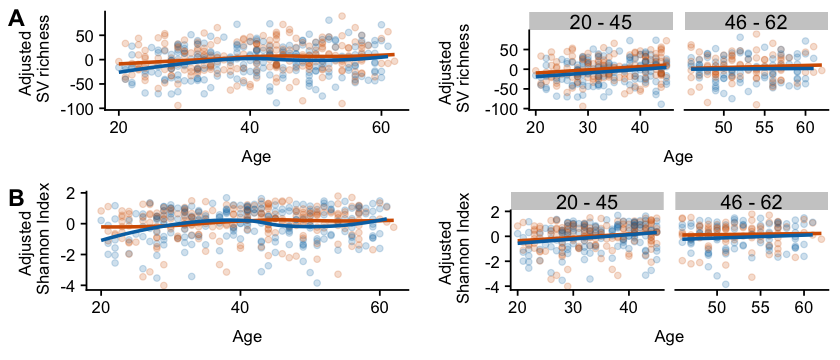

In [23]:
richness_age = ggplot(adj_alpha_age, aes(x = age, y = observed_otus, color = sex)) +
  geom_point(alpha = plot_alpha) +
  geom_smooth(method="loess", se = F) +
  labs(x = "Age", y = "Adjusted \n SV richness") +
  scale_x_continuous(breaks = pretty_breaks(n = x_breaks)) +
  theme(axis.title = element_text(size=font_size), axis.text=element_text(size=font_size)) +
  scale_color_manual(values=Palette) +
  theme(legend.position="none")

shannon_age = ggplot(adj_alpha_age, aes(x = age, y = shannon, color = sex)) +
  geom_point(alpha = plot_alpha) +
  geom_smooth(method="loess", se = F) +
  labs(x = "Age", y = "Adjusted \n Shannon Index") +
  scale_x_continuous(breaks = pretty_breaks(n = x_breaks)) +
  theme(axis.title = element_text(size=font_size), axis.text=element_text(size=font_size)) +
  scale_color_manual(values=Palette) +
  theme(legend.position="none")

richness_age_range = ggplot(adj_alpha_age, aes(x = age, y = observed_otus, color = sex)) +
  geom_point(alpha = plot_alpha) +
  geom_smooth(method="lm", se = F) + 
  facet_wrap(~ age_range, scales = "free_x") +
  labs(x = "Age", y = "Adjusted \n SV richness") +
  scale_x_continuous(breaks = pretty_breaks(n = x_breaks)) +
  theme(axis.title = element_text(size=font_size), axis.text=element_text(size=font_size)) +
  scale_color_manual(values=Palette) +
  theme(legend.position="none")

shannon_age_range = ggplot(adj_alpha_age, aes(x = age, y = shannon, color = sex)) +
  geom_point(alpha = plot_alpha) +
  geom_smooth(method="lm", se = F) + 
  facet_wrap(~ age_range, scales = "free_x") +
  labs(x = "Age", y = "Adjusted \n Shannon Index") +
  scale_x_continuous(breaks = pretty_breaks(n = x_breaks)) +
  theme(axis.title = element_text(size=font_size), axis.text=element_text(size=font_size)) +
  scale_color_manual(values=Palette) +
  theme(legend.position="none")

alpha_adj_gph = plot_grid(richness_age, richness_age_range,
            shannon_age, shannon_age_range, 
          ncol = 2, labels = c("A", "", "B", ""))

print(alpha_adj_gph)

ggsave(filename = "./images/col_alpha_adj.png", 
       plot = alpha_adj_gph, device = "png", dpi = "print", width = 7, height = 7)


Test the association between
age and sex in each age group separately.

In [24]:
# Fit separate linear models by each age group
# SV richness
richness_group_lm = adj_alpha_age %>% group_by(age_range) %>%
  do(richn_lm = lm(observed_otus ~ sex + age, data = .)  %>% summary())

# get the coefficients by group in a tidy data_frame
otu_group_coef = tidy(richness_group_lm, richn_lm)
otu_group_coef

# R2 of the regression
otu_group_R2 = glance(richness_group_lm, richn_lm)
otu_group_R2

# Shannon index
shannon_group_lm = adj_alpha_age %>% group_by(age_range) %>%
  do(shann_lm = lm(shannon ~ sex + age, data = .) %>% summary())

# get the coefficients by group in a tidy data_frame
shannon_group_coef = tidy(shannon_group_lm, shann_lm)
shannon_group_coef

# R2 of the regression
shannon_group_R2 = glance(shannon_group_lm, shann_lm)
shannon_group_R2

age_range,term,estimate,std.error,statistic,p.value
20 - 45,(Intercept),-27.8872209,8.9981565,-3.0992149,0.0021430414
20 - 45,sexMale,-7.4697221,3.6195044,-2.0637417,0.0399872415
20 - 45,age,0.8692987,0.2554461,3.4030608,0.0007662548
46 - 62,(Intercept),-11.0675588,32.1132048,-0.3446420,0.7308218477
46 - 62,sexMale,-4.8154529,5.1750713,-0.9305095,0.3535269048
46 - 62,age,0.3168735,0.6080385,0.5211405,0.6029985347


age_range,r.squared,adj.r.squared,sigma,statistic,p.value,df
20 - 45,0.053625447,0.046692300,30.03501,7.7346475,0.000540265,3
46 - 62,0.006868271,-0.005703016,32.77718,0.5463459,0.580151875,3


age_range,term,estimate,std.error,statistic,p.value
20 - 45,(Intercept),-1.02208195,0.319891909,-3.1950853,0.0015619666
20 - 45,sexMale,-0.09087887,0.128676377,-0.7062592,0.4806292698
20 - 45,age,0.03055497,0.009081322,3.3645952,0.0008764807
46 - 62,(Intercept),-0.68046820,1.033008075,-0.6587250,0.5110312037
46 - 62,sexMale,-0.23511184,0.166470164,-1.4123362,0.1598175982
46 - 62,age,0.01594625,0.019559203,0.8152812,0.4161386168


age_range,r.squared,adj.r.squared,sigma,statistic,p.value,df
20 - 45,0.04109153,0.034066556,1.067769,5.849352,0.003255231,3
46 - 62,0.01590151,0.003444563,1.054367,1.276518,0.281868671,3


## Description of participants
Finally, we will generate a table that summarizes the characteristics of the subjects

In [25]:
colnames(alpha_age_dat)
# Variables to summarize
cont_vars = c("observed_otus", "shannon", "age", "ms_score")
# Categories by which the participants are grouped
strat_vars = c( "sex", "age_range")

# Create the table object
col_subj_des = CreateTableOne(vars = cont_vars, strata = strat_vars, 
                              data = alpha_age_dat, test = F)

# Print the table
col_subj_des

[1] "shannon"       "observed_otus" "age"           "sex"          
[5] "age_range"     "ms_score"

                           Stratified by sex:age_range
                            Female:20 - 45 Male:20 - 45   Female:46 - 62
  n                            143            133             83        
  observed_otus (mean (SD)) 120.41 (30.21) 110.71 (31.06) 123.33 (32.75)
  shannon (mean (SD))         4.60 (1.05)    4.48 (1.12)    4.73 (0.99) 
  age (mean (SD))            33.83 (7.21)   34.21 (6.98)   52.48 (4.14) 
  ms_score (mean (SD))       -1.14 (3.07)    0.64 (3.67)   -0.36 (3.06) 
                           Stratified by sex:age_range
                            Male:46 - 62  
  n                             78        
  observed_otus (mean (SD)) 116.13 (33.95)
  shannon (mean (SD))         4.45 (1.13) 
  age (mean (SD))            52.90 (4.42) 
  ms_score (mean (SD))        1.39 (2.71) 

## Session info
For reproducibility matters

In [26]:
sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS High Sierra 10.13.6

Matrix products: default
BLAS/LAPACK: /Users/jdelacuesta/miniconda3/lib/R/lib/libRblas.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] bindrcpp_0.2.2  lspline_1.0-0   tableone_0.10.0 scales_0.5.0   
 [5] broom_0.5.0     forcats_0.3.0   stringr_1.3.1   dplyr_0.7.6    
 [9] purrr_0.2.5     readr_1.1.1     tidyr_0.8.1     tibble_1.4.2   
[13] tidyverse_1.2.1 cowplot_0.9.4   ggplot2_3.0.0  

loaded via a namespace (and not attached):
 [1] pbdZMQ_0.3-3     tidyselect_0.2.4 repr_0.15.0      splines_3.5.1   
 [5] haven_2.1.0      lattice_0.20-35  labelled_2.1.0   colorspace_1.3-2
 [9] htmltools_0.3.6  base64enc_0.1-3  survival_2.42-6  rlang_0.2.1     
[13] e1071_1.7-0.1    pillar_1.3.0     glue_1.3.0       withr_2.1.2 